# Hotel demand forecast

# Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./Data/hotel_bookings.csv')\
    .rename(columns={'arrival_date_year':'year','arrival_date_month':'month','arrival_date_day_of_month':'day'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   year                            119390 non-null  int64  
 4   month                           119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   day                             119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [153]:
df['hotel'].unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [154]:
df['month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [2]:
def monthToNum(shortMonth):
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
    }[shortMonth]

In [3]:
df['month'] = df['month'].apply(monthToNum)
df['date']= pd.to_datetime(df[["year", "month", "day"]])

df = df[(df['is_canceled']==0) & (df['hotel']=='Resort Hotel')]
t_df = df.groupby(['date'])['hotel'].count().reset_index().rename(columns={'hotel':'y','date':'ds'})


In [157]:
import plotly.express as px

fig = px.line(t_df, x="ds", y="y", title='hotel demands')
fig.show()

In [158]:
t_df['ds'].min()

Timestamp('2015-07-01 00:00:00')

In [159]:
t_df['ds'].max()

Timestamp('2017-08-31 00:00:00')

In [83]:
len(t_df)

793

In [4]:
train_df = t_df.loc[(t_df['ds']>='2015-07-01') & (t_df['ds']<'2017-08-01')]
test_df = t_df.loc[(t_df['ds']>='2017-08-01') & (t_df['ds']<'2017-09-01')]

In [161]:
fig = px.line(train_df, x="ds", y="y", title='hotel reservations')
fig.show()

# ARIMA

Time lags are determined at which the partial autocorrelation function (PACF)  and Autocorrelation function (ACF) plots start to decay towards zero. PACF is used for Auto Regression and only detects the direct effect of values in previous time lags. Moving Average uses ACF and detects the direct and indirect effects of values in previous time lags.
Differencing is a technique used to make a time series stationary by removing trends and seasonality. Two common methods to convert a time series non-stationary to stationary are: differencing Y(t) - Y(t-N) or log operations to smooth exponential curves Log(exp(x)=x).

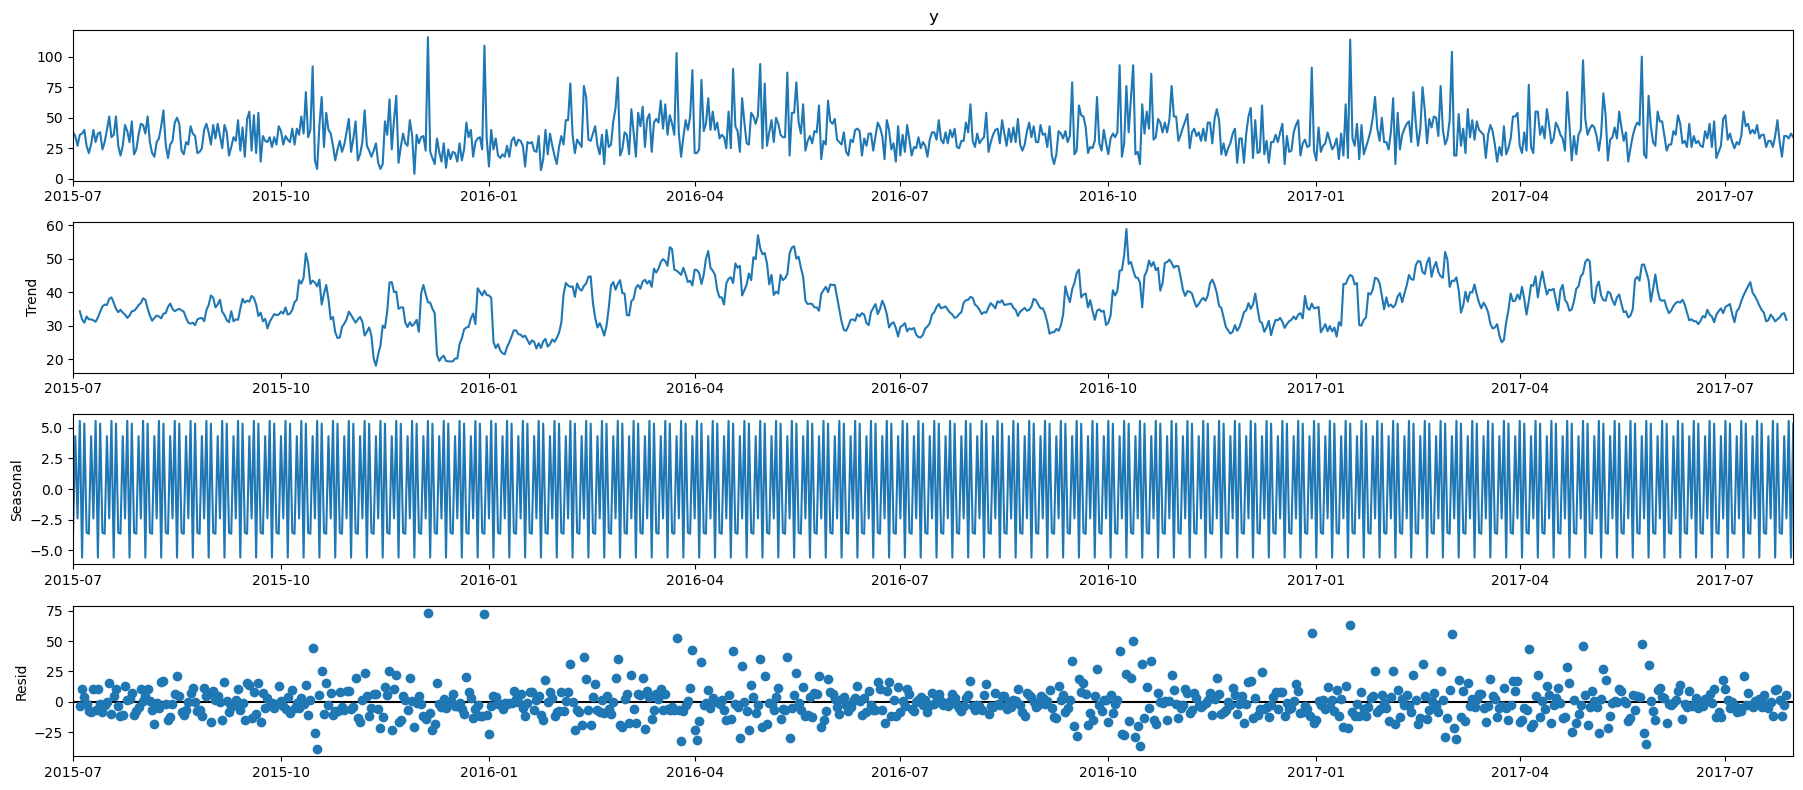

In [162]:
from pylab import rcParams
import statsmodels.api as sm

train_df_arima = train_df.copy()
train_df_arima = train_df_arima.set_index('ds')

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(train_df_arima['y'], model='additive')
fig = decomposition.plot()


In [163]:
decomposition.seasonal[:10]

ds
2015-07-01   -3.663643
2015-07-02    4.327098
2015-07-03   -2.405707
2015-07-04    5.575775
2015-07-05   -5.610733
2015-07-06    5.352230
2015-07-07   -3.575019
2015-07-08   -3.663643
2015-07-09    4.327098
2015-07-10   -2.405707
Name: seasonal, dtype: float64

To initiate the construction of an ARIMA model, the initial step involves determining the appropriate value for the differencing parameter (d) by assessing the stationarity of the dataset. In this case, the Augmented Dickey-Fuller (ADF) test yields a small p-value (<0.05), indicating that the time series data does not necessitate differencing.

In [164]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(train_df_arima['y'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.5559549516967515
p-value: 0.00015559448784235313


Moving forward, the subsequent section focuses on determining the appropriate number of autoregressive (AR) terms by analyzing the Partial Autocorrelation Plot. Based on the observed graphs, we determine that the optimal value for the p-parameter, representing the number of AR terms, should be 1.

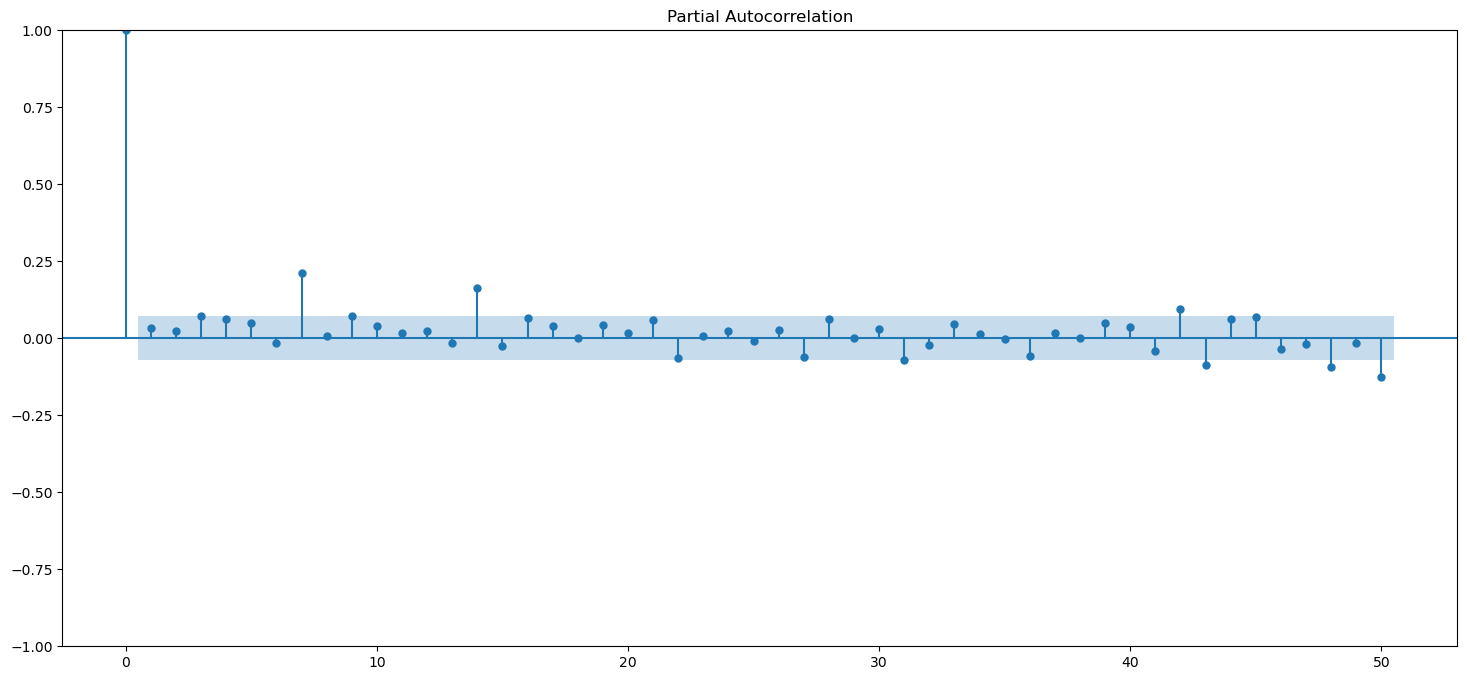

In [165]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(train_df_arima['y'], lags=50)

Lastly, we proceed to identify the appropriate number of Moving Average (MA) terms by examining the Autocorrelation Function (ACF) plot. Upon analyzing the graphs, we determine that the ideal value for the q-parameter, representing the number of MA terms, should be 1.

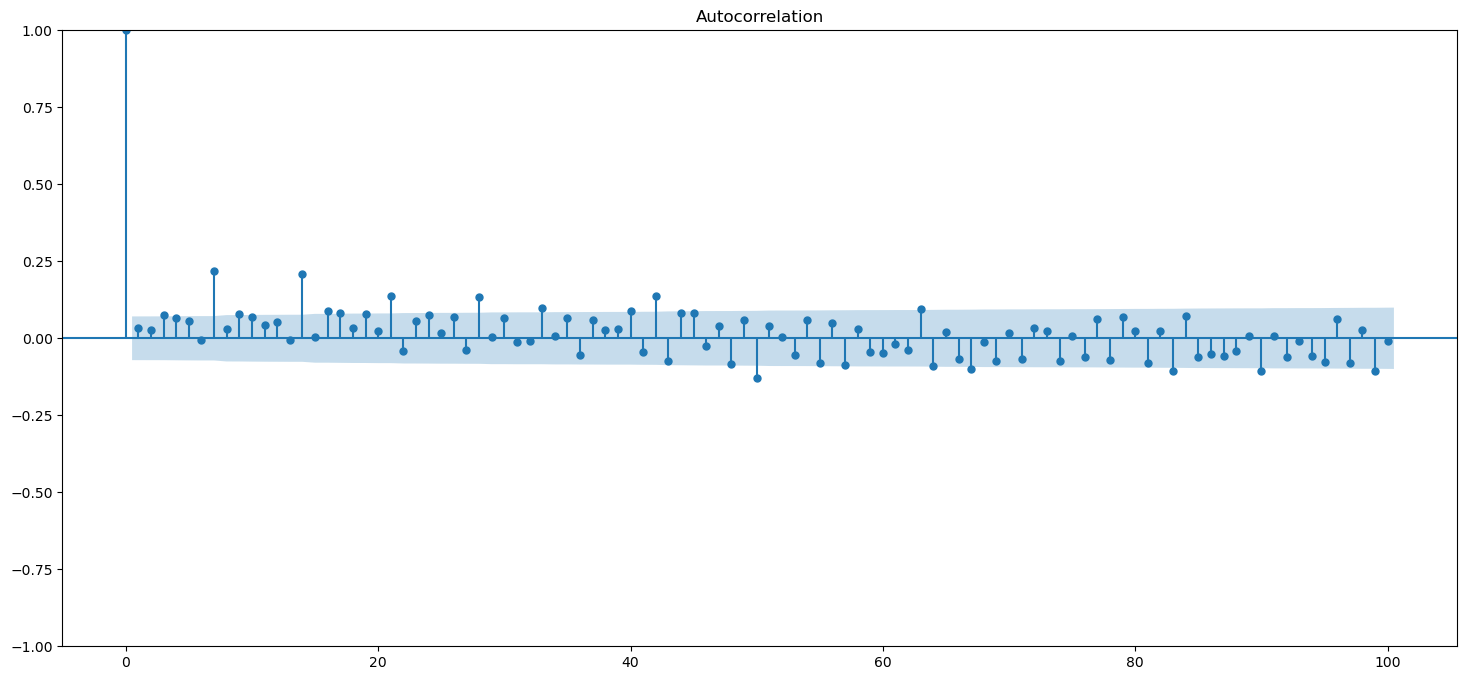

In [166]:
acf = plot_acf(train_df_arima['y'], lags=100)

In [167]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(train_df_arima['y'],          
                           trace=True, error_action='ignore', suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6358.232, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6874.540, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6661.828, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6358.249, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6872.541, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6360.755, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6358.523, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6360.084, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6359.136, Time=0.64 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6358.925, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6358.045, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6358.343, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=6359.876, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6358.751, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  762
Model:               SARIMAX(3, 1, 5)   Log Likelihood               -3167.165
Date:                Sat, 20 May 2023   AIC                           6352.330
Time:                        12:34:09   BIC                           6394.041
Sample:                    07-01-2015   HQIC                          6368.391
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5636      0.165     -9.471      0.000      -1.887      -1.240
ar.L2         -1.5328      0.141    -10.836      0.000      -1.810      -1.256
ar.L3         -0.7159      0.161     -4.436      0.000      -1.032      -0.400
ma.L1          0.5848      0.167      3.512      0.000       0.258       0.911
ma.L2         -0.0234      0.052     -0.451      0.652      -0.125       0.078
ma.L3         -0.7649      0.042    -18.053      0.000      -0.848      -0.682
ma.L4         -0.6407      0.155     -4.145      0.000      -0.944      -0.338
ma.L5          0.1140      0.038      2.978      0.003       0.039       0.189
sigma2       242.4747      7.553     32.104      0.000     227.672     257.278
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               846.01
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             1.49
Prob(H) (two-sided):                  0.94   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [168]:
import statsmodels.api as sm
mod = sm.tsa.arima.ARIMA(train_df_arima['y'],order=(3, 1, 5))

results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  762
Model:                 ARIMA(3, 1, 5)   Log Likelihood               -3167.165
Date:                Sat, 20 May 2023   AIC                           6352.330
Time:                        12:34:09   BIC                           6394.041
Sample:                    07-01-2015   HQIC                          6368.391
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5636      0.165     -9.471      0.000      -1.887      -1.240
ar.L2         -1.5328      0.141    -10.836      0.000      -1.810      -1.256
ar.L3         -0.7159      0.161     -4.436      0.0

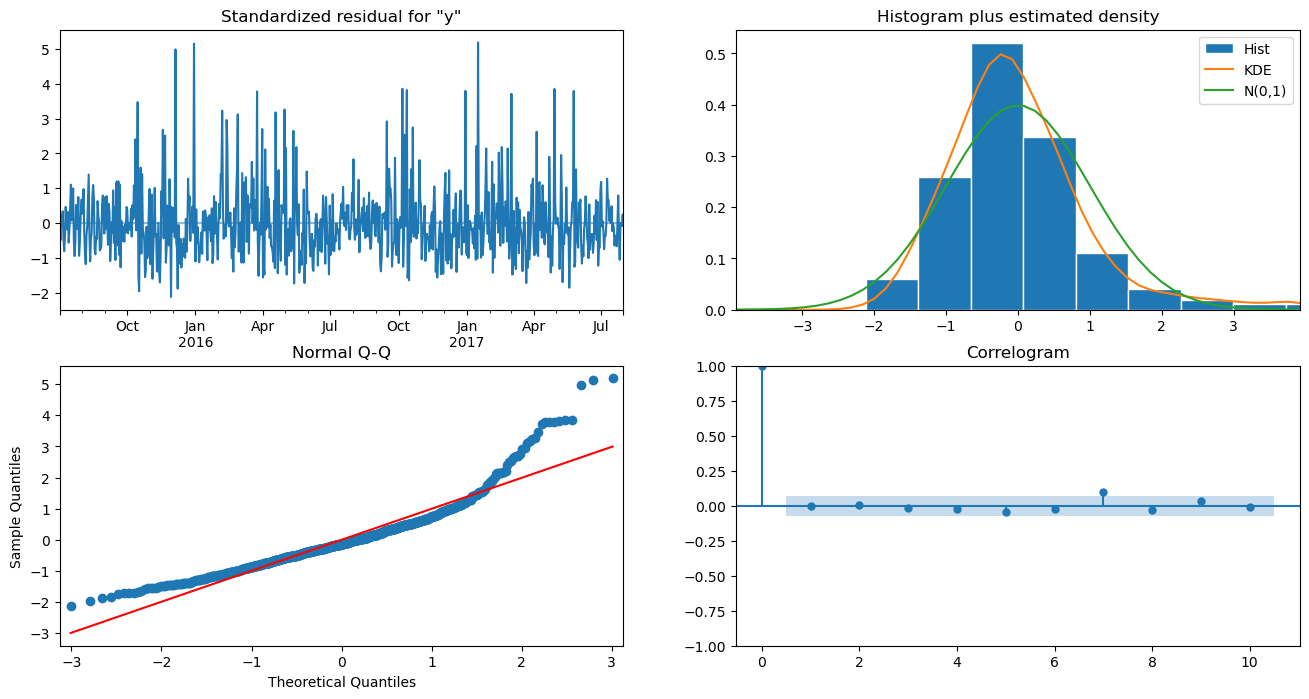

In [169]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [170]:
train_df_arima.index.max()

Timestamp('2017-07-31 00:00:00')

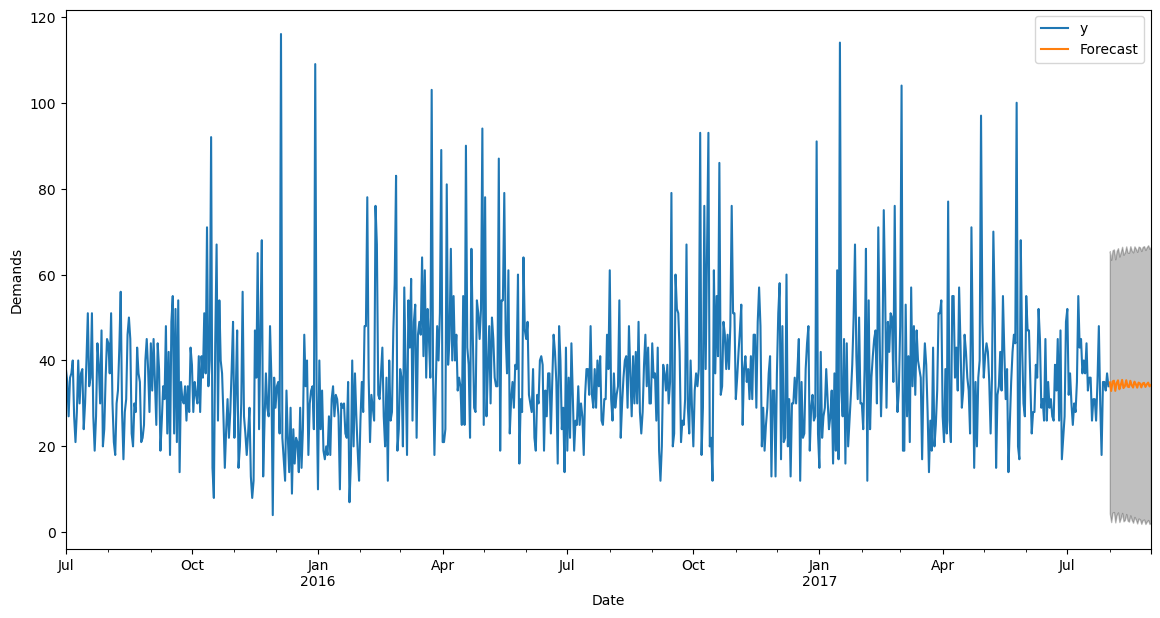

In [171]:
pred_uc = results.get_forecast(steps=31)
pred_ci = pred_uc.conf_int()
ax = train_df_arima.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Demands')
plt.legend()
plt.show()

Text(0, 0.5, 'Bookings')

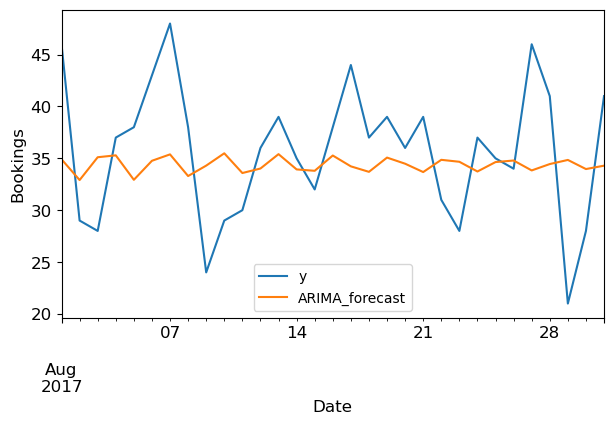

In [172]:
pred= pd.DataFrame(results.forecast(steps=31)).reset_index()
test_output = test_df.merge(pred,left_on='ds', right_on='index', how='inner').reset_index()
test_output = test_output.rename(columns={'predicted_mean':'ARIMA_forecast'})
test_output_viz = test_output[['ds','y','ARIMA_forecast']]
test_output_viz= test_output_viz.set_index('ds')

test_output_viz.plot.line(figsize=(7,4),fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Bookings', fontsize=12)

In [173]:
from sklearn.metrics import mean_absolute_error
print('Time Series: {:.0f}'.format(mean_absolute_error(test_output[['ARIMA_forecast']], test_output[['y']])))

Time Series: 5


# Prophet

12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing


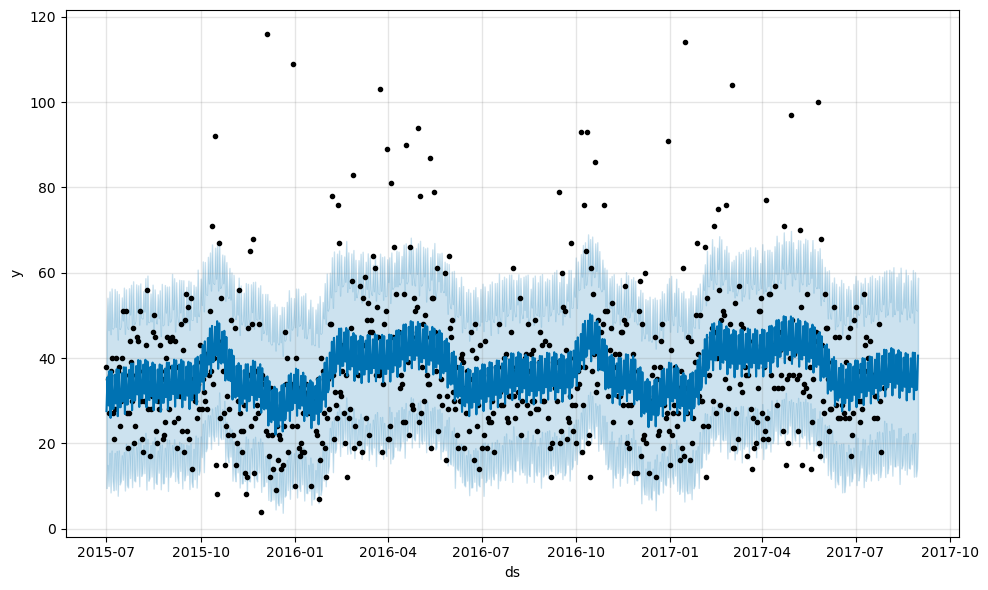

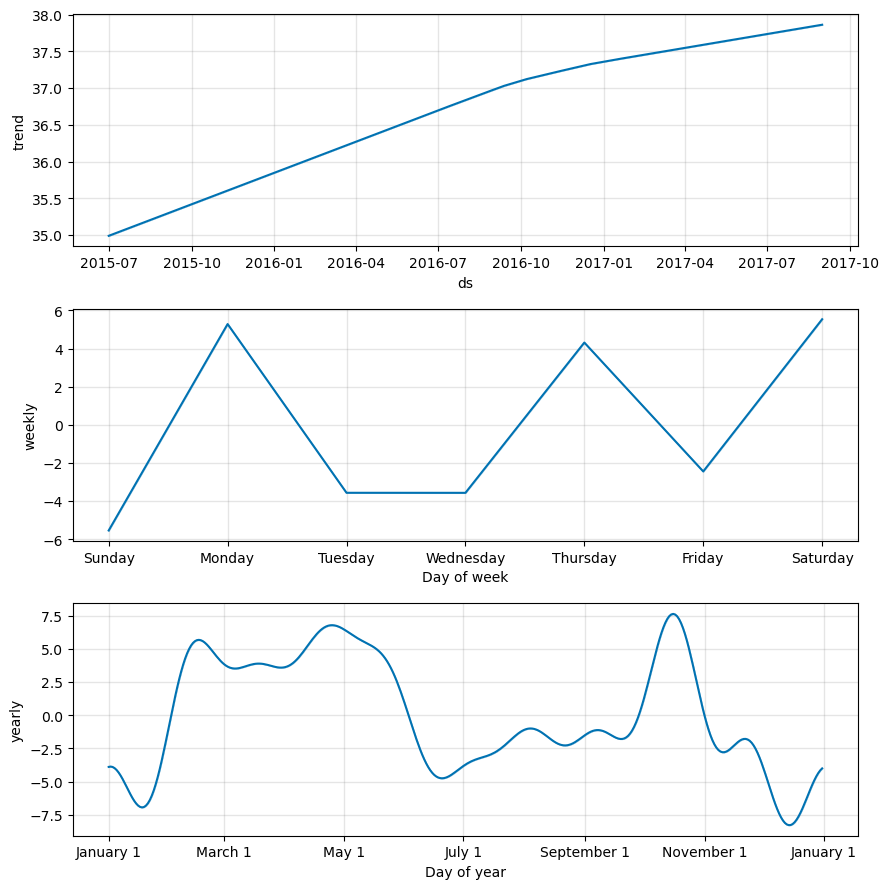

In [174]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

train_df_prophet = train_df.copy()
model = Prophet(daily_seasonality=False)
model.fit(train_df_prophet)
forecast = model.make_future_dataframe(periods=31)
pred = model.predict(forecast)

prophet_plot = model.plot(pred)
prophet_plot2 = model.plot_components(pred)


Text(0, 0.5, 'Bookings')

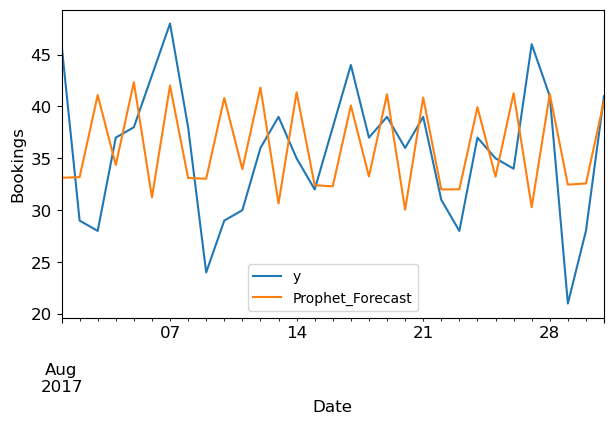

In [175]:
forecast_df = test_df.merge(pred,left_on='ds', right_on='ds', how='inner').rename(columns={'yhat':'Prophet_Forecast'})


test_output_viz = forecast_df[['ds','y','Prophet_Forecast']]
test_output_viz= test_output_viz.set_index('ds')

test_output_viz.plot.line(figsize=(7,4),fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Bookings', fontsize=12)


In [176]:
from sklearn.metrics import mean_absolute_error
print('Time Series: {:.0f}'.format(mean_absolute_error(forecast_df[['Prophet_Forecast']], forecast_df[['y']])))


Time Series: 6


# LSTM

In [84]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

# Generate the dataset windows
x_train= train_df[['y']]
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [86]:
import tensorflow as tf
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

2023-05-25 09:36:08.168949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 09:36:08.170752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 09:36:08.172047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-05-25 09:36:08.937379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 09:36:08.939116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 09:36:08.940346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 [==============================] - 9s 16ms/step - loss: 12.9261 - mae: 13.4155
Epoch 2/100
24/24 [==============================] - 0s 15ms/step - loss: 11.0084 - mae: 11.5010
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 10.7482 - mae: 11.2365
Epoch 4/100
24/24 [==============================] - 0s 13ms/step - loss: 11.6888 - mae: 12.1799
Epoch 5/100
24/24 [==============================] - 0s 14ms/step - loss: 11.4614 - mae: 11.9505
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 11.0092 - mae: 11.4957
Epoch 7/100
24/24 [==============================] - 0s 13ms/step - loss: 10.9279 - mae: 11.4137
Epoch 8/100
24/24 [==============================] - 0s 12ms/step - loss: 10.8765 - mae: 11.3659
Epoch 9/100
24/24 [==============================] - 0s 12ms/step - loss: 11.0206 - mae: 11.5135
Epoch 10/100
24/24 [==============================] - 0s 14ms/step - loss: 10.8918 - mae: 11.3813
Epoch 11/100
24/24 [=====================

In [ ]:
recent_data = X_test[-1]  # Most recent window of known data
predictions = []
for _ in range(30):
    prediction = model.predict(recent_data.reshape(1, window_size, num_features))
    predictions.append(prediction)
    recent_data = np.append(recent_data[1:], prediction)

# Print the predictions for the next 30 days
print(predictions)

In [87]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast



In [106]:
x_test= test_df[['y']]
forecast_series = t_df[['y']][len(x_train)-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()

test_df = x_test.reset_index()\
    .merge(pd.DataFrame(results).rename(columns={0:'LSTM_forecast'}), left_index=True, right_index=True)

Text(0, 0.5, 'Bookings')

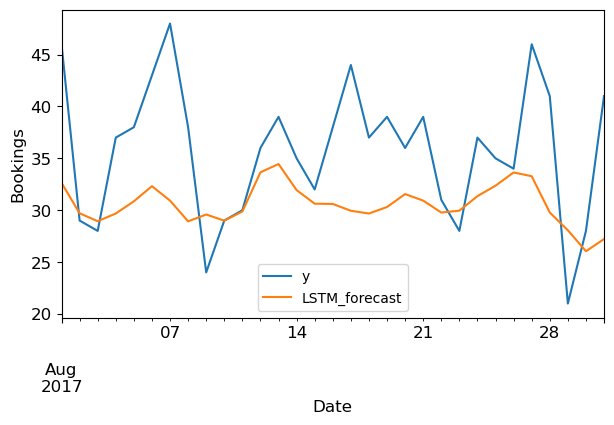

In [122]:
test_df = test_df.set_index('ds')
test_df.plot(figsize=(7,4), fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Bookings', fontsize=12)

In [123]:
from sklearn.metrics import mean_absolute_error
print('Time Series: {:.0f}'.format(mean_absolute_error(test_df[['LSTM_forecast']], test_df[['y']])))

Time Series: 6


In [55]:

from keras.models import Sequential
from keras.layers import LSTM, Dense

In [81]:
def load_data(df, sequence_length=20, split=0.8, test_units=31):
    data_all = np.array(df).astype(float)   
    #print(data_all.shape) # (241,1)
    scaler = MinMaxScaler()
    data_all = scaler.fit_transform(data_all) 
    data = []
   
    for i in range(len(data_all) - sequence_length - 1):
       
        data.append(data_all[i: i + sequence_length + 1])
    reshaped_data = np.array(data).astype('float64')

    x = reshaped_data[:, :-1] 
    y = reshaped_data[:, -1] 
   
    split_boundary = int(len(data_all) - sequence_length - 1) - test_units
    train_x = x[: split_boundary] 
    test_x = x[split_boundary:]   
 
    train_y = y[: split_boundary] 
    test_y = y[split_boundary:]  

    return train_x, train_y, test_x, test_y, scaler

def build_model():
    model = Sequential()     
    model.add(LSTM(input_shape=(10,1),units=256,unroll=False))
    model.add(Dense(units=1)) 
    model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
    return model

def train_model(train_x, train_y, test_x, test_y):
    model = build_model()
    try:
        model.fit(train_x, train_y, batch_size=100, epochs=300, validation_split=0.1)
        predict = model.predict(test_x)
        predict = np.reshape(predict, (predict.size, )) 
    except KeyboardInterrupt:
        print(predict)
        print(test_y)
    return predict, test_y


ddprice=t_df[['y']]
    
train_x, train_y, test_x, test_y, scaler =load_data(ddprice, sequence_length=10, split=0.8)
predict_y, test_y = train_model(train_x, train_y, test_x, test_y)
predict_y = scaler.inverse_transform([[i] for i in predict_y]) 
test_y = scaler.inverse_transform(test_y)  

Epoch 1/300


2023-05-24 18:20:54.713289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-24 18:20:54.714225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-24 18:20:54.715927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 87ms/step - loss: 0.0433 - accuracy: 0.0015 - val_loss: 0.0203 - val_accuracy: 0.0000e+00
Epoch 2/300


2023-05-24 18:20:56.731186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-24 18:20:56.733047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-24 18:20:56.735096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 47ms/step - loss: 0.0234 - accuracy: 0.0015 - val_loss: 0.0160 - val_accuracy: 0.0000e+00
Epoch 3/300
7/7 [==============================] - 0s 31ms/step - loss: 0.0229 - accuracy: 0.0015 - val_loss: 0.0136 - val_accuracy: 0.0000e+00
Epoch 4/300
7/7 [==============================] - 0s 29ms/step - loss: 0.0215 - accuracy: 0.0015 - val_loss: 0.0131 - val_accuracy: 0.0000e+00
Epoch 5/300
7/7 [==============================] - 0s 41ms/step - loss: 0.0212 - accuracy: 0.0015 - val_loss: 0.0131 - val_accuracy: 0.0000e+00
Epoch 6/300
7/7 [==============================] - 0s 38ms/step - loss: 0.0212 - accuracy: 0.0015 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 7/300
7/7 [==============================] - 0s 40ms/step - loss: 0.0210 - accuracy: 0.0015 - val_loss: 0.0130 - val_accuracy: 0.0000e+00
Epoch 8/300
7/7 [==============================] - 0s 32ms/step - loss: 0.0211 - accuracy: 0.0015 - val_loss: 0.0129 - val_accuracy: 0.0000e+00
Epoc

2023-05-24 18:21:59.889318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-24 18:21:59.891021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-24 18:21:59.892108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Text(0, 0.5, 'Bookings')

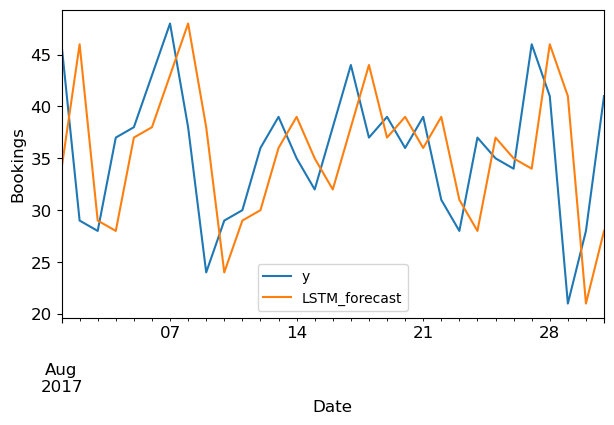

In [82]:
test_df['LSTM_forecast'] = test_y
#test_df = test_df.set_index('ds')
test_df.plot(figsize=(7,4), fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Bookings', fontsize=12)

In [80]:
from sklearn.metrics import mean_absolute_error
print('Time Series: {:.0f}'.format(mean_absolute_error(test_df[['LSTM_forecast']], test_df[['y']])))

Time Series: 7


# Pickup method

In [182]:
df['lead_time2'] = np.where(df["lead_time"] >365,365, df["lead_time"])
train_matrix = df.loc[df['date']<'2017-08-01'].groupby(['date','lead_time2'])['hotel'].count().reset_index()
train_matrix = train_matrix.sort_values(['date', 'lead_time2'], ascending=[True, False])
train_matrix['bookings_cumsum'] = train_matrix.groupby(['date'])['hotel'].transform(pd.Series.cumsum)
train_matrix = train_matrix.rename(columns={'hotel':'bookings'})
train_matrix


,date,lead_time2,bookings,bookings_cumsum
27,2015-07-01,365,1,1
26,2015-07-01,342,1,2
25,2015-07-01,181,1,3
24,2015-07-01,149,2,5
23,2015-07-01,145,1,6
...,...,...,...,...
15201,2017-07-31,23,1,28
15200,2017-07-31,22,2,30
15199,2017-07-31,5,1,31
15198,2017-07-31,1,2,33


In [183]:
date_index = df.groupby("date")['hotel'].count().reset_index()
date_index['max'] = 365
date_index['min'] = 0
date_index = date_index.loc[date_index.index.repeat(date_index['max'].sub(date_index['min']) + 1)]      
date_index['lead_time'] = date_index['min'].add(date_index.groupby(level=0).cumcount())
date_index = date_index.drop(columns=['hotel','max','min'])
date_index = date_index.sort_values(['date', 'lead_time'], ascending=[True, False])

date_index

,date,lead_time
0,2015-07-01,365
0,2015-07-01,364
0,2015-07-01,363
0,2015-07-01,362
0,2015-07-01,361
...,...,...
792,2017-08-31,4
792,2017-08-31,3
792,2017-08-31,2
792,2017-08-31,1


In [184]:
train_pickup_df = date_index.merge(train_matrix, left_on=['date','lead_time'], right_on=['date','lead_time2'], how='left').rename(columns={'hotel':'bookings'})
train_pickup_df['bookings_cumsum2']= train_pickup_df.groupby('date')['bookings_cumsum'].ffill()
train_pickup_df['bookings_cumsum2']= train_pickup_df['bookings_cumsum2'].fillna(0)
train_pickup_df

,date,lead_time,lead_time2,bookings,bookings_cumsum,bookings_cumsum2
0,2015-07-01,365,365.0,1.0,1.0,1.0
1,2015-07-01,364,NaN,NaN,NaN,1.0
2,2015-07-01,363,NaN,NaN,NaN,1.0
3,2015-07-01,362,NaN,NaN,NaN,1.0
4,2015-07-01,361,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...
290233,2017-08-31,4,NaN,NaN,NaN,0.0
290234,2017-08-31,3,NaN,NaN,NaN,0.0
290235,2017-08-31,2,NaN,NaN,NaN,0.0
290236,2017-08-31,1,NaN,NaN,NaN,0.0


In [185]:
total =  df.groupby("date")['hotel'].count().reset_index()
roh = train_pickup_df[['date','lead_time','bookings_cumsum2']].merge(total, left_on=['date'], right_on=['date'], how='inner')
roh['pickup'] = roh['hotel'] - roh['bookings_cumsum2']
lookup = roh.loc[roh['date']<'2017-08-01'].groupby('lead_time')['pickup'].mean().round().reset_index()
lookup

,lead_time,pickup
0,0,0.0
1,1,4.0
2,2,6.0
3,3,7.0
4,4,8.0
...,...,...
361,361,36.0
362,362,36.0
363,363,36.0
364,364,36.0


In [186]:
test_matrix = df.loc[df['date']>='2017-08-01'].groupby(['date','lead_time2'])['hotel'].count().reset_index()
test_matrix = test_matrix.sort_values(['date', 'lead_time2'], ascending=[True, False])
test_matrix['bookings_cumsum'] = test_matrix.groupby(['date'])['hotel'].transform(pd.Series.cumsum)
test_matrix['bookdate'] = test_matrix['date']  - pd.to_timedelta(test_matrix['lead_time2'], unit='D')
test =test_matrix.loc[test_matrix['bookdate']<'2017-08-01'].rename(columns={'hotel':''})

test

,date,lead_time2,,bookings_cumsum,bookdate
30,2017-08-01,336,1,1,2016-08-30
29,2017-08-01,263,1,2,2016-11-11
28,2017-08-01,230,3,5,2016-12-14
27,2017-08-01,188,1,6,2017-01-25
26,2017-08-01,187,2,8,2017-01-26
...,...,...,...,...,...
806,2017-08-31,46,1,18,2017-07-16
805,2017-08-31,45,1,19,2017-07-17
804,2017-08-31,43,1,20,2017-07-19
803,2017-08-31,40,1,21,2017-07-22


In [187]:
last= test.groupby('date')['lead_time2'].min().reset_index()
pickup = test.merge(last, left_on=['date','lead_time2'], right_on=['date','lead_time2'], how='inner')\
    .merge(lookup, left_on=['lead_time2'], right_on=['lead_time'], how='inner')

pickup['pickup_forecast'] = pickup['bookings_cumsum'] + pickup['pickup']
pcikup_forecast = pickup[['date','pickup_forecast']].merge(total, left_on='date', right_on='date')
pcikup_forecast = pcikup_forecast.rename(columns={'hotel':'y'})
pcikup_forecast

,date,pickup_forecast,y
0,2017-08-01,54.0,46
1,2017-08-04,36.0,37
2,2017-08-02,36.0,29
3,2017-08-06,44.0,43
4,2017-08-03,34.0,28
5,2017-08-05,42.0,38
6,2017-08-10,34.0,29
7,2017-08-07,57.0,48
8,2017-08-08,49.0,38
9,2017-08-16,46.0,38


In [188]:
from sklearn.metrics import mean_absolute_error
print('Time Series: {:.0f}'.format(mean_absolute_error(pcikup_forecast[['pickup_forecast']], pcikup_forecast[['y']])))

Time Series: 6


Text(0, 0.5, 'Bookings')

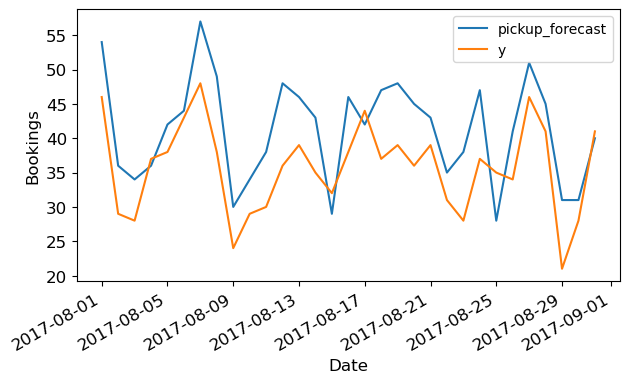

In [189]:
pcikup_forecast = pcikup_forecast.set_index('date')
pcikup_forecast.plot(figsize=(7,4),fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Bookings', fontsize=12)